In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from pylab import rcParams
import itertools
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import sys

from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Bidirectional
from keras.layers import LSTM
import warnings

from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import mean_squared_error

import os

import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

In [5]:
#import 
df = pd.read_excel('resursa_gaze.xls')
print(df)
print(len(df))

      perioada  resursa
0   2014-01-01     1142
1   2014-02-01      999
2   2014-03-01     1021
3   2014-04-01      937
4   2014-05-01      949
..         ...      ...
106 2022-11-01      963
107 2022-12-01     1201
108 2023-01-01      873
109 2023-02-01      901
110 2023-03-01      900

[111 rows x 2 columns]
111


In [6]:
df.columns

Index(['perioada', 'resursa'], dtype='object')

In [7]:
#set index data
df=df.set_index('perioada')

In [8]:
df.columns
df

,resursa
perioada,
2014-01-01,1142
2014-02-01,999
2014-03-01,1021
2014-04-01,937
2014-05-01,949
...,...
2022-11-01,963
2022-12-01,1201
2023-01-01,873


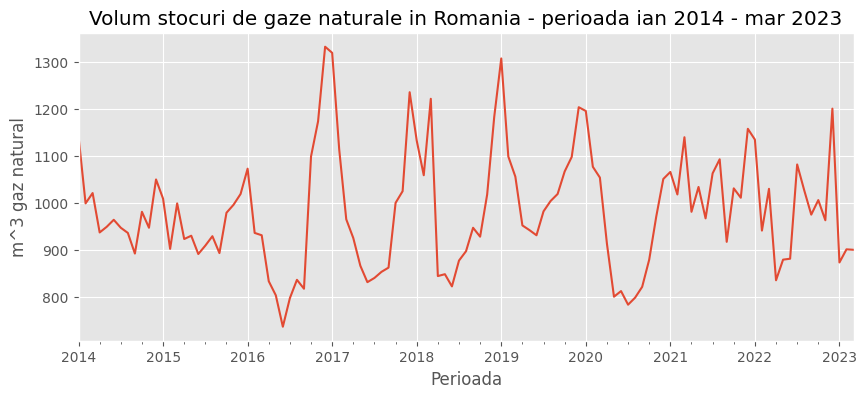

In [17]:
#selectare doar componenta resursa - ca reprezentand totalul e oferta de gaze (productia interna+importuri)
#grafic cu evolutia stocurilor de resursa de gaze naturale in Romania
ax= df['resursa'].plot(figsize=(10,4),label='Resursa GN')
ax.set_xlabel("Perioada")
ax.set_ylabel('m^3 gaz natural')
ax.set_title("Volum stocuri de gaze naturale in Romania - perioada ian 2014 - mar 2023")
plt.show()

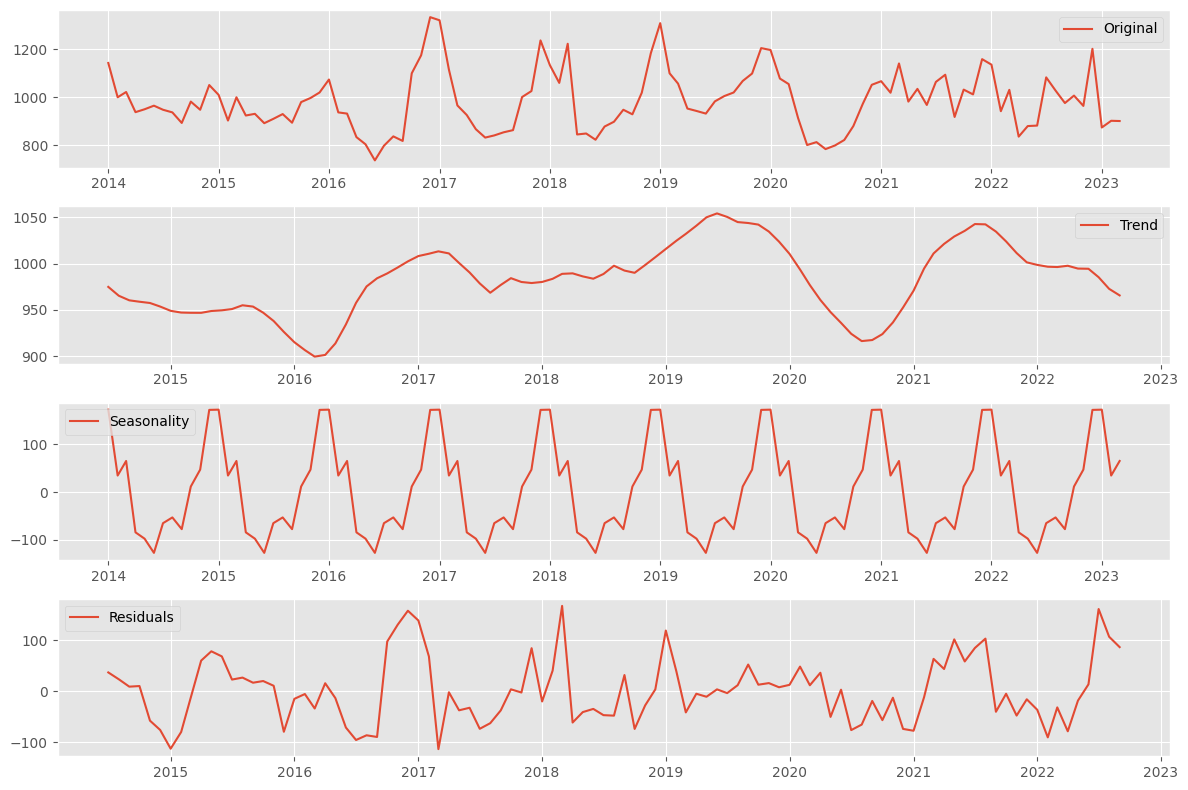

In [18]:
#Resursa time-series decomposition
decomposition = seasonal_decompose(df,period=12)
rcParams['figure.figsize'] = 12, 8

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [19]:
#testare stationaritate serie 
def test_stationarity(timeseries):
    rcParams['figure.figsize'] = 10, 6
    rolmean = timeseries.rolling(12).mean() #allows you to calculate moving avg
    rolstd = timeseries.rolling(12).std() 
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print('p-value=', dftest[1])
    

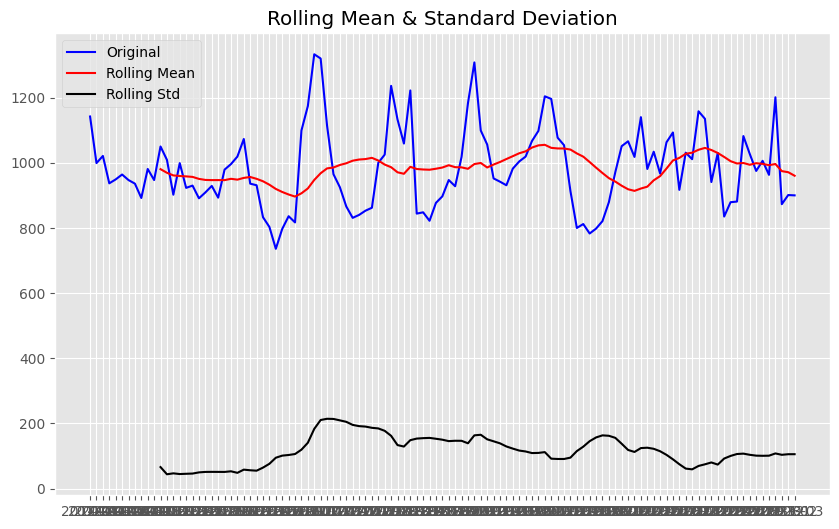

Results of Dickey-Fuller Test:
p-value= 0.052383086965345035


In [25]:
test_stationarity(df)
#cum p-value 0.05<0.1 => se refuza ipoteza nula cum ca seria nu ar fi stationara
#si din graficul de mai jos se poate observa ca seria este STATIONARA

In [20]:
#split in seturi de testare si antrenare
#target:previziune 15 valori (anul 2022 + 3 luni din 2023) - aprox. 14%
#set de antrenare - 86% din serie 96
#set de testare - 14% din serie 15
X=df
train_size = int(len(X) * 0.87)
trainset, testset= X[0:train_size], X[train_size:]
train_size

96

In [21]:
#acuratetea predictiei 

def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    performance_data= {'MSE':round(mse, 2),
                      'RMSE':round(np.sqrt(mse), 2),
                       'MAPE':round(mape, 2)
                      }
    return performance_data

def performance2(y_true, y_pred): 
    #y_true, y_pred = np.array(y_true), np.array(y_pred)
    mse = ((y_pred - y_true) ** 2).mean()
    mape= np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print(' The MSE of forecasts is {}'.format(round(mse, 2))+
                  '\n The RMSE of forecasts is {}'.format(round(np.sqrt(mse), 2))+
                  '\n The MAPE of forecasts is {}'.format(round(mape, 2))))

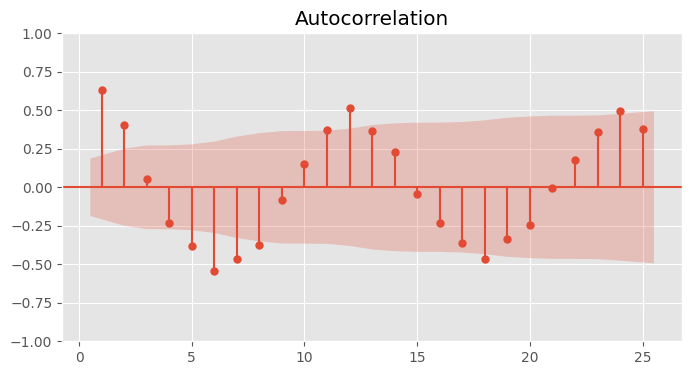

In [25]:
#cum seria este stationara,aceasta nu trebuie diferentiata
#asadar pentru prognoza puteam incepe cu un proces SARIMA

#auto arima model
from statsmodels.graphics.tsaplots import plot_acf
fig,ax = plt.subplots(1,1,figsize=(8,4))
plot_acf(df,ax=ax,zero=False,lags=25)
plt.show()

#din ACF cum periodicitatea seriei este la 12 laguri
#se poate observa cum valoarea pt lag 24 este ultima semnificativa in afara intervalului
#astfel lagul maximal pentru coeficientrii modelului ARIMA vor fi 2 

In [26]:
## Find optimal order
import pmdarima as pm
model_1 = pm.auto_arima(trainset,seasonal=True, m=12,d=0, D=1, max_p=2, max_q=2,
                       trace=True,error_action='ignore',suppress_warnings=True) 

# Print model summary
print(model_1.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1050.472, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=983.583, Time=0.27 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1048.874, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1004.358, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=969.568, Time=0.65 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=1.14 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1022.464, Time=0.41 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=971.476, Time=0.61 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=971.503, Time=0.72 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=988.691, Time=0.59 sec
 ARIMA(2,0,1)(2,1,0)[12] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(1,0,0)(2,1,0)[12]             : AIC=968.08

In [ ]:
#modelul optim identificat este SARIMAX(1, 0, 0)x(2, 1, 0, 12) 

In [27]:
#fitting model
sarima_model = sm.tsa.statespace.SARIMAX(trainset,
                                order=(1, 0, 0),
                                seasonal_order=(2, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
sarima_fit = sarima_model.fit()
print(sarima_fit.summary().tables[1])

C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\CSIE ANUL III\SEM 2\PACHETE SOFTWARE\pythonProject1\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6047      0.084      7.227      0.000       0.441       0.769
ar.S.L12      -0.7983      0.119     -6.685      0.000      -1.032      -0.564
ar.S.L24      -0.4526      0.143     -3.169      0.002      -0.733      -0.173
sigma2      5275.6633   1045.052      5.048      0.000    3227.398    7323.928


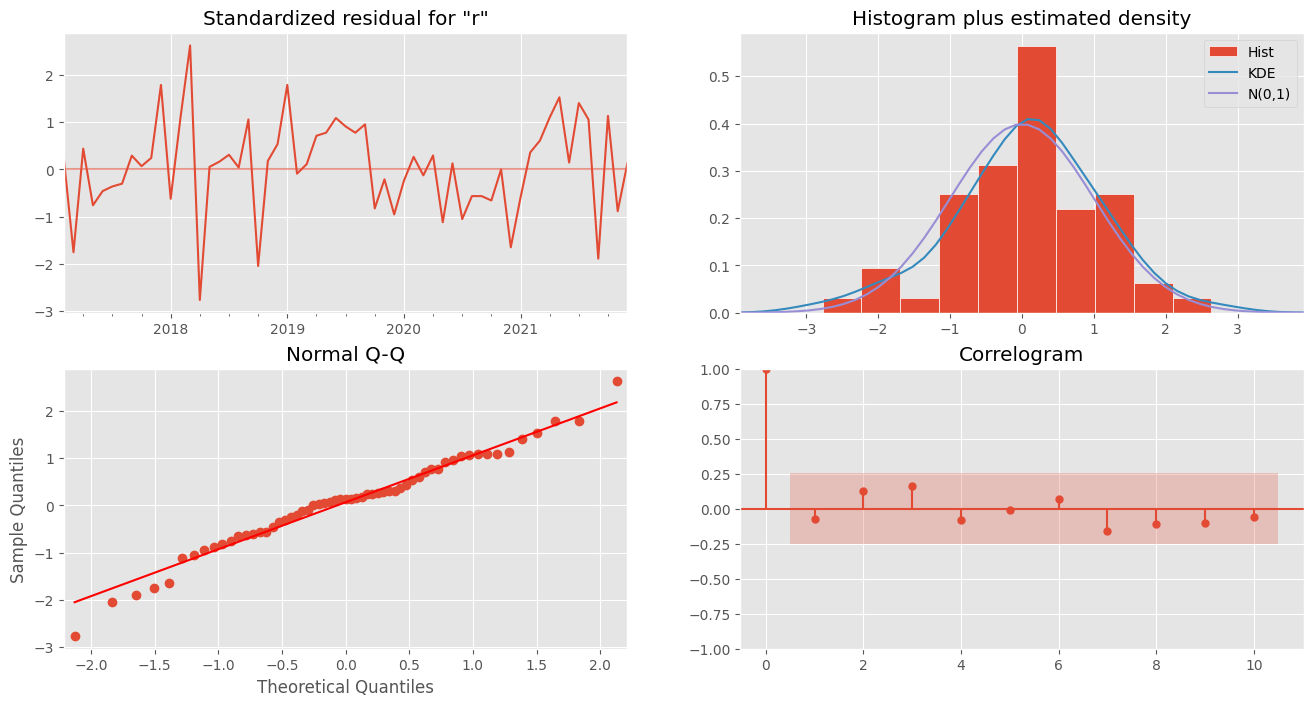

In [37]:
#grafic
sarima_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

#conform graficelor ipotezele pe reziduuri sunt respectate
#reziduurile par a urmari o evolutie homocedastica si o distributie normala
#mai mult,conform corelogramei nu exista autocorelare in serie
#modelul ales este unul valid

In [ ]:
#conform graficelor si ipotezelelor pe reziduuri putem interpreta:
#reziduurile au tendinta de heteroscedasticitate
#nu sunt normal distribuite conform histogramei,dar au tendinta de simetrie
#nu exista autocorelare in reziduuri 

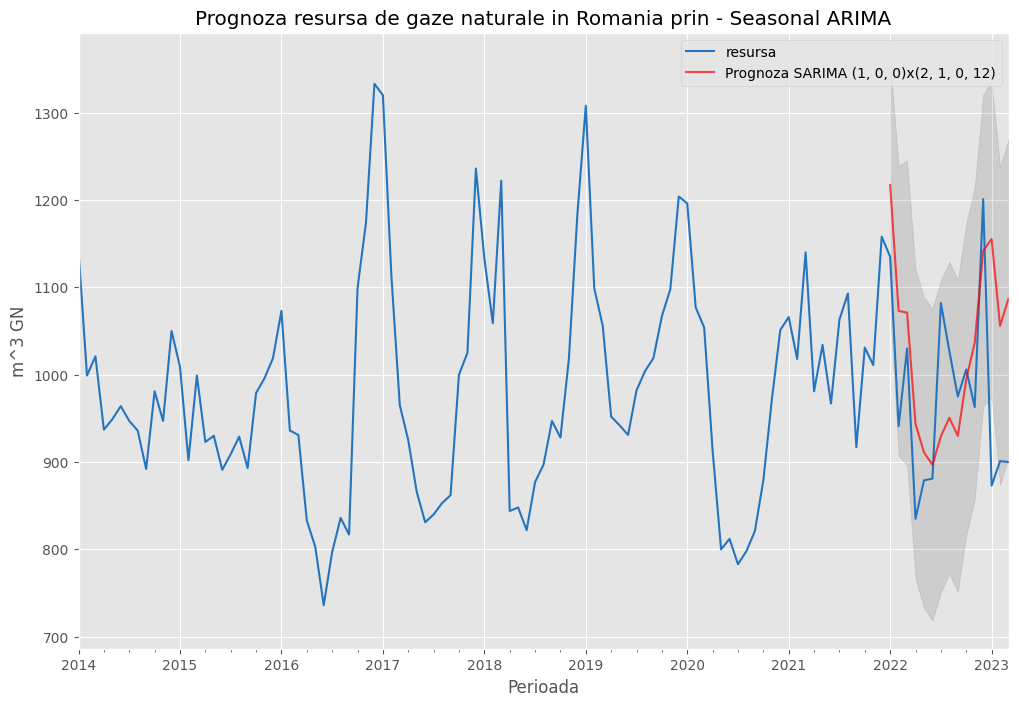

In [30]:
# One step ahead forecast
sarima_predict = sarima_fit.get_prediction(start=pd.to_datetime('2022-01-01'), end=pd.to_datetime('2023-03-01')
                                           ,dynamic=False)
sarima_predict_conf = sarima_predict.conf_int()
#observed plot
ax = df.plot(label='Initial',color='#2574BF')
#predicted plot
rcParams['figure.figsize'] = 14, 7

sarima_predict.predicted_mean.plot(ax=ax, label='Prognoza SARIMA (1, 0, 0)x(2, 1, 0, 12)', alpha= 0.7, color='red') 
ax.fill_between(sarima_predict_conf.index,
                #lower sales
                sarima_predict_conf.iloc[:, 0],
                #upper sales
                sarima_predict_conf.iloc[:, 1], color='k', alpha=0.1)
plt.title('Prognoza resursa de gaze naturale in Romania prin - Seasonal ARIMA')
plt.xlabel('Perioada')
plt.ylabel('m^3 GN')
plt.legend()
plt.show()


In [31]:
#acuratete predictie 
sarima_results1=performance(df["resursa"],sarima_predict.predicted_mean)
sarima_results1

{'MSE': 14519.15, 'RMSE': 120.5, 'MAPE': 10.26}

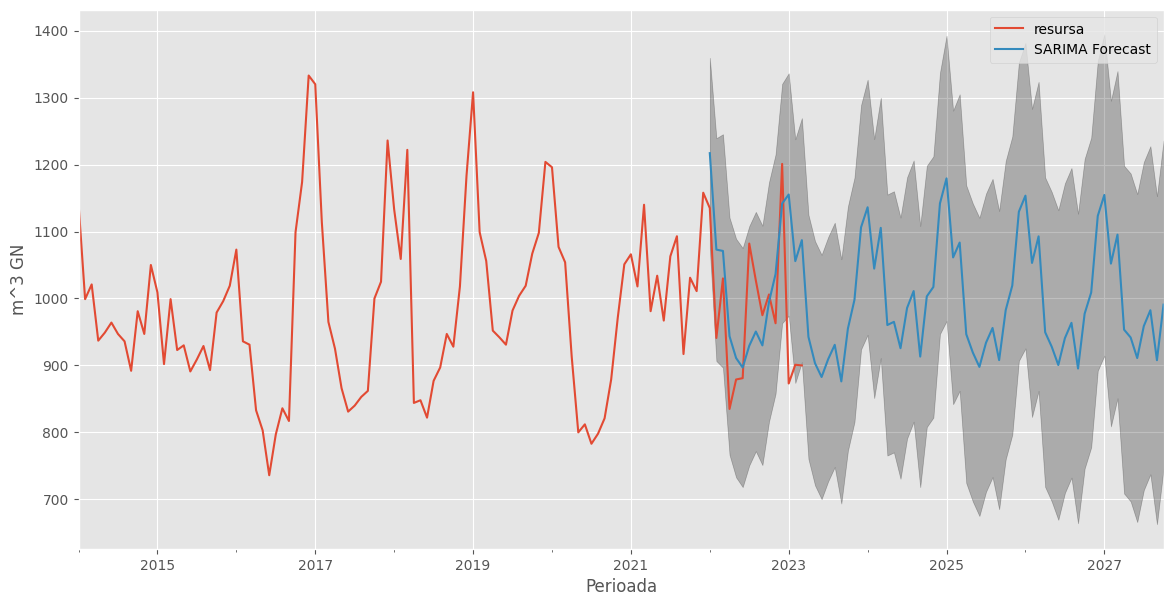

In [32]:
#prognoza perioadele urmatoare
furthur_predict = sarima_fit.get_forecast(steps=70)
furthur_conf = furthur_predict.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
furthur_predict.predicted_mean.plot(ax=ax, label='SARIMA Forecast')
ax.fill_between(furthur_conf.index,
                furthur_conf.iloc[:, 0],
                furthur_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Perioada')
ax.set_ylabel('m^3 GN')
plt.legend()
plt.show()

In [34]:
#2.LSTM Method
#Long Short-Term Memory method

#set testare si antrenare 
train, test = np.array(df[:-15]), np.array(df[-15:])
train= train.reshape(-1,1)
test= test.reshape(-1,1)

In [35]:
#scalarea datelor

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [36]:
n_input = 15
# univariate
n_features = 1
#TimeseriesGenerator automatically transform a univariate time series dataset into a supervised learning problem.
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=10)

In [37]:
#1.model bidirectional LSTM

# define model
model_bi = Sequential()
model_bi.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(15, 1)))
model_bi.add(Dense(1))
model_bi.compile(optimizer='adam', loss='mse')

In [38]:
model_bi.fit_generator(generator,epochs=100)

Epoch 1/100


C:\Users\user\AppData\Local\Temp\ipykernel_2396\2076291188.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_bi.fit_generator(generator,epochs=100)


9/9 [==============================] - 2s 5ms/step - loss: 0.2409
Epoch 2/100
9/9 [==============================] - 0s 6ms/step - loss: 0.1390
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0567
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 0.0624
Epoch 5/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0510
Epoch 6/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0470
Epoch 7/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0470
Epoch 8/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0496
Epoch 9/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0488
Epoch 10/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0490
Epoch 11/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0448
Epoch 12/100
9/9 [==============================] - 0s 6ms/step - loss: 0.0449
Epoch 13/100
9/9 [==============================] - 0s 6ms/step - loss: 0

In [39]:
pred_list_b = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list_b.append(model_bi.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_b[i]]],axis=1)

df_predict_bi = pd.DataFrame(scaler.inverse_transform(pred_list_b),
                          index=df[-n_input:].index, columns=['Prediction'])
df_predict_bi

1/1 [==============================] - 0s 22ms/step


,Prediction
perioada,
2022-01-01,1143.341018
2022-02-01,1128.448663
2022-03-01,1099.663933
2022-04-01,1055.325912
2022-05-01,1013.232456
2022-06-01,972.280783
2022-07-01,976.893853
2022-08-01,986.585077
2022-09-01,1025.862097


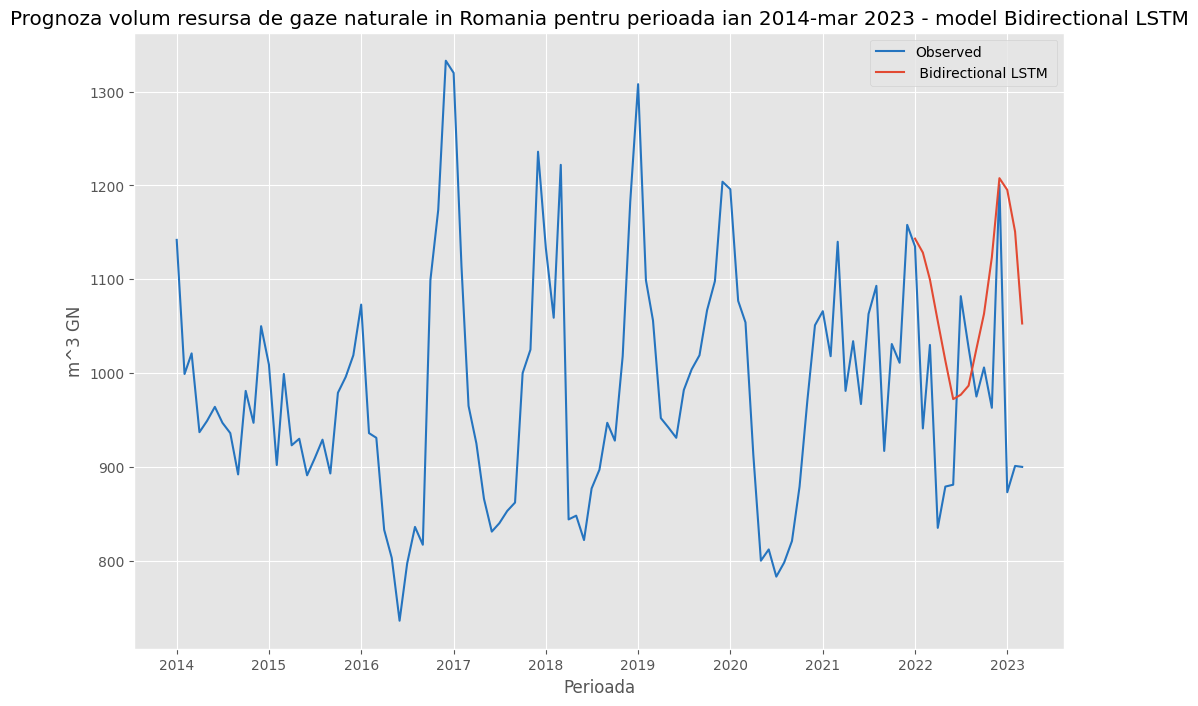

In [40]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Observed",color='#2574BF')
plt.plot(df[96:].index,df_predict_bi,label=" Bidirectional LSTM ")
plt.title('Prognoza volum resursa de gaze naturale in Romania pentru perioada ian 2014-mar 2023 - model Bidirectional LSTM')
plt.xlabel('Perioada')
plt.ylabel('m^3 GN')
plt.legend()
plt.show()

In [41]:
bi_lstm= performance(df[-15:]['resursa'],df_predict_bi['Prediction'])
bi_lstm_predict=df_predict_bi['Prediction']
bi_lstm

{'MSE': 23256.41, 'RMSE': 152.5, 'MAPE': 13.52}

In [52]:
#3. CNN -Convolutional Neural Network 
dfcnn= np.array(df)
dfcnn= dfcnn.reshape(-1,1)
#Scale data
scaler = MinMaxScaler()
ts = scaler.fit_transform(dfcnn)

In [53]:
#Set the timestep
timestep = 12
X= []
Y=[]
raw_data=ts
for i in range(len(raw_data)- (timestep)):
    X.append(raw_data[i:i+timestep])
    Y.append(raw_data[i+timestep])


X=np.asanyarray(X)
Y=np.asanyarray(Y)
#Set the trainset
X_train = X[:84,:,:]  
Y_train = Y[:84] 
#Set the testset
X_test = X[84:,:,:]  
Y_test= Y[84:]

In [54]:
#define model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(12, 1)))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dense(1))
cnn_model.compile(optimizer='adam', loss='mse',metrics='mae')


# fit model
model_nn=cnn_model.fit(X_train, Y_train, epochs=200, verbose=1) 

Epoch 1/200
3/3 [==============================] - 1s 5ms/step - loss: 0.2021 - mae: 0.3811
Epoch 2/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0942 - mae: 0.2375
Epoch 3/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0688 - mae: 0.2143
Epoch 4/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0525 - mae: 0.1825
Epoch 5/200
3/3 [==============================] - 0s 7ms/step - loss: 0.0449 - mae: 0.1649
Epoch 6/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0368 - mae: 0.1509
Epoch 7/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0295 - mae: 0.1380
Epoch 8/200
3/3 [==============================] - 0s 5ms/step - loss: 0.0235 - mae: 0.1206
Epoch 9/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0214 - mae: 0.1165
Epoch 10/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0206 - mae: 0.1157
Epoch 11/200
3/3 [==============================] - 0s 6ms/step - loss: 0.0205 

In [55]:
model_nn.params

{'verbose': 1, 'epochs': 200, 'steps': 3}

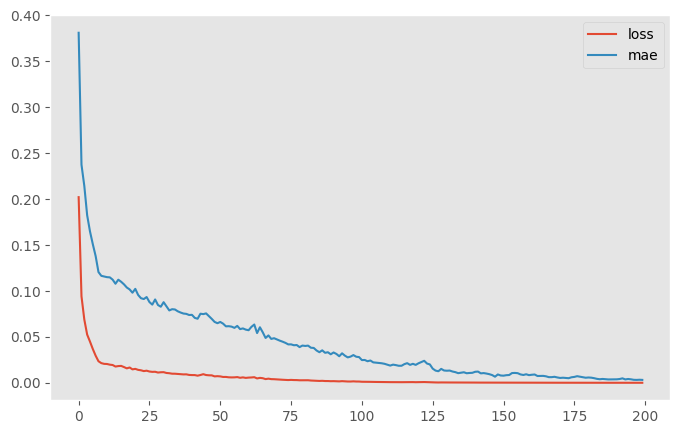

In [56]:
pd.DataFrame(model_nn.history).plot(figsize=(8, 5))
plt.grid()

In [57]:
# Validate data
preds = cnn_model.predict(X_test)
preds=np.array(preds)
preds=preds.reshape(-1,1)
preds = scaler.inverse_transform(preds)


Y_test=np.asanyarray(Y_test)  
Y_test=Y_test.reshape(-1,1) 
Y_test = scaler.inverse_transform(Y_test)


Y_train=np.asanyarray(Y_train)  
Y_train=Y_train.reshape(-1,1) 
Y_train = scaler.inverse_transform(Y_train)


1/1 [==============================] - 0s 84ms/step


In [58]:
cnn= performance(Y_test,preds)
cnn_predict= preds.reshape((15,))
cnn

{'MSE': 11117.16, 'RMSE': 105.44, 'MAPE': 9.6}

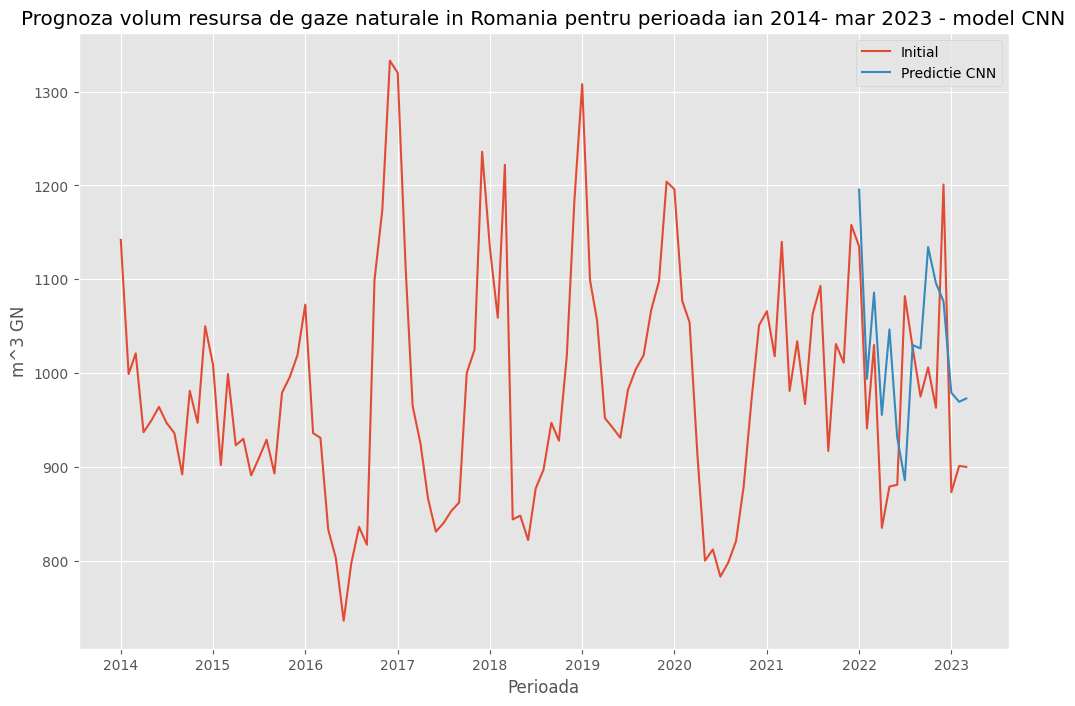

In [59]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Initial")
plt.plot(df[96:].index,preds,label="Predictie CNN")
plt.title('Prognoza volum resursa de gaze naturale in Romania pentru perioada ian 2014- mar 2023 - model CNN')
plt.xlabel('Perioada')
plt.ylabel('m^3 GN')
plt.legend()
plt.show()

In [60]:
# intialise data of lists. 
prediction_data = {'Model':['SARIMA','Bidirectional LSTM','CNN'],
                   
                    'MSE':[sarima_results1['MSE'], 
                           bi_lstm['MSE'],cnn['MSE']],
                  'RMSE':[sarima_results1['RMSE'], 
                        bi_lstm['RMSE'],cnn['RMSE']],
                  'MAPE':[sarima_results1['MAPE'],
                          bi_lstm['MAPE'],cnn['MAPE']]}
 
# Create DataFrame
prediction_table = pd.DataFrame(prediction_data)
prediction_table

,Model,MSE,RMSE,MAPE
0,SARIMA,14519.15,120.50,10.26
1,Bidirectional LSTM,23256.41,152.50,13.52
2,CNN,11117.16,105.44,9.60


In [61]:
prediction_data = {
        'Test Set':df[-15:]["resursa"],
        'SARIMA ':sarima_predict.predicted_mean,
        'Bidirectional LSTM':df_predict_bi['Prediction'],
        'CNN': cnn_predict}

prediction_table = pd.DataFrame(prediction_data)
prediction_table
    

,Test Set,SARIMA,Bidirectional LSTM,CNN
2022-01-01,1135,1217.063985,1143.341018,1195.688721
2022-02-01,941,1072.996302,1128.448663,993.847839
2022-03-01,1030,1071.001088,1099.663933,1085.856567
2022-04-01,835,943.610443,1055.325912,955.459778
2022-05-01,879,911.003116,1013.232456,1046.525024
2022-06-01,881,896.841990,972.280783,931.045593
2022-07-01,1082,929.367398,976.893853,885.643372
2022-08-01,1027,950.626532,986.585077,1029.875366
2022-09-01,975,929.914147,1025.862097,1026.265381
2022-10-01,1006,994.705505,1063.224949,1134.398315


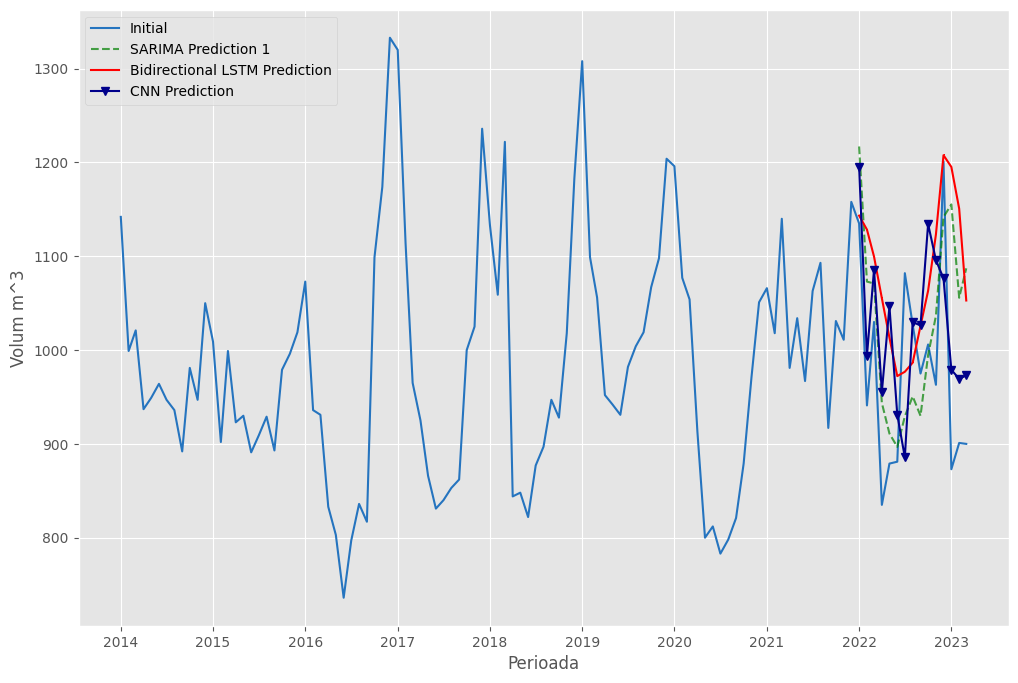

In [62]:
# report performance
rcParams['figure.figsize'] = 12, 8
# line plot of observed vs predicted
plt.plot(df.index,df,label="Initial",color='#2574BF')

#SARIMA
plt.plot(sarima_predict.predicted_mean, label='SARIMA Prediction 1', alpha= 0.7,linestyle= "--", color='g')

#Bidirectional LSTM
plt.plot(df[96:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')

#CNN
plt.plot(df[96:].index,preds,label="CNN Prediction",marker='v',color='darkblue')

plt.xlabel('Perioada')
plt.ylabel('Volum m^3')
plt.legend(loc='upper left')
plt.show()

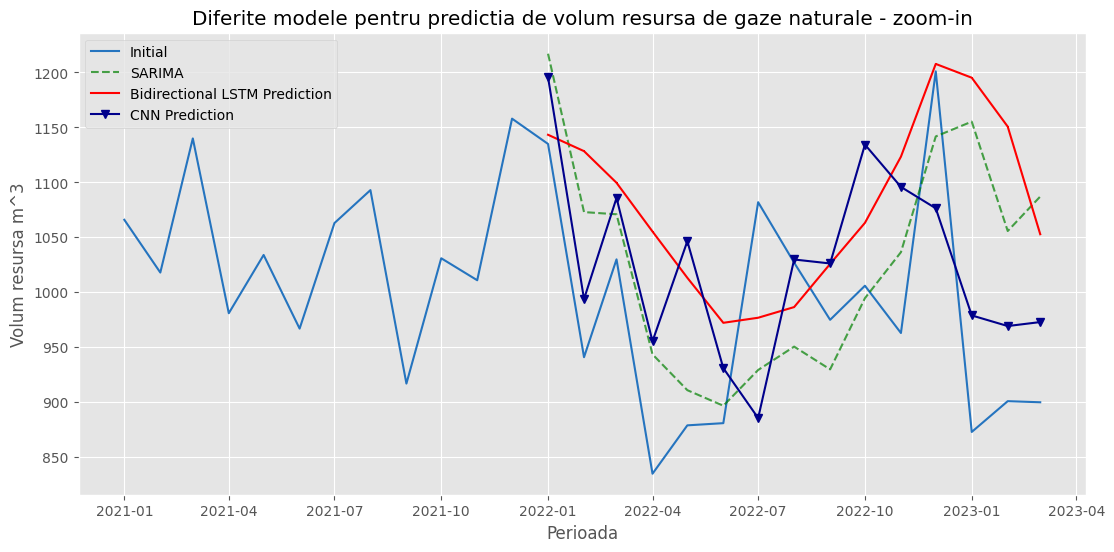

In [63]:
from pylab import rcParams
rcParams['figure.figsize'] = 13, 6
#observed plot
plt.plot(df[84:].index, df[84:], color='#2574BF',label='Initial')
#SARIMA
plt.plot(sarima_predict.predicted_mean, label='SARIMA', alpha= 0.7,linestyle= "--", color='g')

#Bidirectional LSTM
plt.plot(df[96:].index,df_predict_bi,label="Bidirectional LSTM Prediction",marker=',',color='r')

#CNN
plt.plot(df[96:].index,preds,label="CNN Prediction",marker='v',color='darkblue')

plt.xlabel('Perioada')
plt.ylabel('Volum resursa m^3')
plt.legend()
plt.title('Diferite modele pentru predictia de volum resursa de gaze naturale - zoom-in')
plt.show()